In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import time
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score

In [3]:
batchsize = 64
lr=0.01
momentum=0.9
weight_decay=1e-4
num_epoch=60

In [4]:
x = np.loadtxt('Xtr.csv', delimiter=",")
y = np.loadtxt('ytr.csv', delimiter=",")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 100)
mean = x_train.mean(axis = 0)
std = x_train.std(axis = 0)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std
x_train = torch.tensor(x_train, dtype = torch.float)
y_train = torch.tensor(y_train, dtype = torch.long)
x_test = torch.tensor(x_test, dtype = torch.float)
y_test = torch.tensor(y_test, dtype = torch.long)
#mini_batch
dataset_train = TensorDataset(x_train, y_train)
dataset_test = TensorDataset(x_test, y_test)
dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batchsize, shuffle=True)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
!nvidia-smi

Using cuda device
Tue Dec  5 18:25:31 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.17                 Driver Version: 546.17       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   36C    P0              16W /  80W |      0MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-------

In [6]:
def text_save(filename, data1):
    file = open(filename,'a')
    for i in range(len(data1)):
        s1 = str(data1[i]).replace('[','').replace(']','')
        s1 = s1.replace("'",'').replace(',','') +'\n' 
        file.write(s1)
    file.close()
    print("保存成功")

In [9]:
class Model_3layers(nn.Module):

    def __init__(self, d_in, d_1, d_2):
        super(Model_3layers, self).__init__()
        self.Dense_1 = nn.Linear(d_in, d_1)
        self.bn1 = nn.BatchNorm1d(d_1)
        self.Dense_2 = nn.Linear(d_1, d_2)
        self.bn2 = nn.BatchNorm1d(d_2)
        self.Dense_3 = nn.Linear(d_2, 26)

    def forward(self, x): 
        out = self.Dense_1(x)
        nn.Dropout(0.4)
        out = F.relu(self.bn1(out))
        out = self.Dense_2(out)
        nn.Dropout(0.4)
        out = F.relu(self.bn2(out))
        out = self.Dense_3(out)
        out = F.relu(out)
        return out
    
class Block_ReLU(nn.Module):

    def __init__(self, d_in, d_1):
        super(Block_ReLU, self).__init__()
        self.Dense_1 = nn.Linear(d_in, d_1)

    def forward(self, x): 
        out = self.Dense_1(x)
        out = F.relu(out)
        return out

class Block_Drop_BN_ReLU(nn.Module):

    def __init__(self, d_in, d_1):
        super(Block_Drop_BN_ReLU, self).__init__()
        self.Dense_1 = nn.Linear(d_in, d_1)
        self.bn1 = nn.BatchNorm1d(d_1)

    def forward(self, x): 
        out = self.Dense_1(x)
        nn.Dropout(0.4)
        out = F.relu(self.bn1(out))
        return out
    
class Block_BN_ReLU(nn.Module):

    def __init__(self, d_in, d_1):
        super(Block_BN_ReLU, self).__init__()
        self.Dense_1 = nn.Linear(d_in, d_1)
        self.bn1 = nn.BatchNorm1d(d_1)

    def forward(self, x): 
        out = self.Dense_1(x)
        out = F.relu(self.bn1(out))
        return out
    
class Block_Drop_ReLU(nn.Module):

    def __init__(self, d_in, d_1):
        super(Block_Drop_ReLU, self).__init__()
        self.Dense_1 = nn.Linear(d_in, d_1)

    def forward(self, x): 
        out = self.Dense_1(x)
        nn.Dropout(0.4)
        out = F.relu(out)
        return out
    
class Block_Drop_BN_Sigmoid(nn.Module):

    def __init__(self, d_in, d_1):
        super(Block_Drop_BN_Sigmoid, self).__init__()
        self.Dense_1 = nn.Linear(d_in, d_1)
        self.bn1 = nn.BatchNorm1d(d_1)

    def forward(self, x): 
        out = self.Dense_1(x)
        nn.Dropout(0.4)
        out = F.sigmoid(self.bn1(out))
        return out
    
class Model(nn.Module):
    def __init__(self, block, num_nodes, num_features, num_classes):
        super(Model, self).__init__()
        
        self.linear1 = block(num_features, num_nodes[0])
        self.layer = self._make_layer(block, num_nodes)
        self.linear2 = nn.Linear(num_nodes[len(num_nodes) - 1], num_classes)
#        self.bn1 = nn.BatchNorm1d(num_classes)

    def _make_layer(self, block, num_nodes):
        layers = []
        for num_node in range(len(num_nodes) - 1):
            layers.append(block(num_nodes[num_node], num_nodes[num_node + 1]))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.linear1(x)
        out = self.layer(out)
        out = self.linear2(out)
        return out

In [77]:
model = Model(Block_Drop_BN_ReLU, [60], 16, 26)
model

Model(
  (linear1): Block_Drop_BN_ReLU(
    (Dense_1): Linear(in_features=16, out_features=60, bias=True)
    (bn1): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer): Sequential()
  (linear2): Linear(in_features=60, out_features=26, bias=True)
)

In [8]:
#minibatch
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    train_classify_loss = 0
    train_custom_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader_train):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        print(batch_idx, '|', len(dataloader_train), '|', train_loss/(batch_idx+1), '|', 100.*correct/total)
    train_acc.append(correct/total)
    train_loss_array.append(train_loss/len(dataloader_train))
#    model_state_path = "data/" +  str(a1) + "_" + str(a2) + "_" + str(epoch) + ".ckpt"
#    torch.save({
#       'epoch': epoch,
#       'model_state_dict': net.state_dict(),
#       'optimizer_state_dict': optimizer.state_dict(),
#       'loss': loss,
#      }, model_state_path)

def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader_test):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print(batch_idx, '|', len(dataloader_test), '|', test_loss/(batch_idx+1), '|', 100.*correct/total)

    valid_acc.append(correct/total)
    valid_loss_array.append(test_loss/len(dataloader_test))

In [14]:
#mini_batch
net = Model(Block_Drop_BN_ReLU, [100, 100, 100, 100], 16, 26)
net.eval()
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)

train_acc = []
valid_acc = []
train_loss_array = []
valid_loss_array = []
criterion = nn.CrossEntropyLoss()

start_time = time.time()
for epoch in range(num_epoch):
    train(epoch)
    test(epoch)
end_time = time.time()
print(end_time - start_time)
    
print("Best test accuracy: {}".format(max(valid_acc)))
#model_state_path = "1.pth"
#torch.save({'model_state_dict': net.state_dict()}, model_state_path)
#text_save("train_acc.txt", train_acc)
#text_save("valid_acc.txt", valid_acc)
#text_save("trainloss.txt", train_loss_array)
#text_save("validloss.txt", valid_loss_array)


Epoch: 0
0 | 125 | 3.3202524185180664 | 3.125
1 | 125 | 3.31086003780365 | 4.6875
2 | 125 | 3.2930589516957602 | 4.6875
3 | 125 | 3.276960849761963 | 5.46875
4 | 125 | 3.2563950538635256 | 5.625
5 | 125 | 3.23915966351827 | 6.510416666666667
6 | 125 | 3.223932777132307 | 7.8125
7 | 125 | 3.1961056292057037 | 9.1796875
8 | 125 | 3.1699701415167914 | 9.895833333333334
9 | 125 | 3.15494589805603 | 10.0
10 | 125 | 3.1305830478668213 | 10.511363636363637
11 | 125 | 3.113806962966919 | 11.328125
12 | 125 | 3.0842913480905385 | 12.5
13 | 125 | 3.05239965234484 | 14.84375
14 | 125 | 3.021702750523885 | 17.083333333333332
15 | 125 | 2.998715341091156 | 18.06640625
16 | 125 | 2.9752650821910187 | 19.301470588235293
17 | 125 | 2.9484618372387357 | 20.225694444444443
18 | 125 | 2.9210015096162496 | 21.463815789473685
19 | 125 | 2.901568078994751 | 22.34375
20 | 125 | 2.875477325348627 | 23.4375
21 | 125 | 2.855494835159995 | 24.076704545454547
22 | 125 | 2.8369170790133267 | 24.52445652173913
23 

48 | 125 | 0.7599765086660579 | 79.1454081632653
49 | 125 | 0.7619371116161346 | 79.0625
50 | 125 | 0.7611503063463697 | 79.07475490196079
51 | 125 | 0.7601638917739575 | 79.0264423076923
52 | 125 | 0.7586132647856226 | 79.09787735849056
53 | 125 | 0.7549579099372581 | 79.10879629629629
54 | 125 | 0.7517415556040677 | 79.20454545454545
55 | 125 | 0.7521290608814785 | 79.26897321428571
56 | 125 | 0.7504439092518991 | 79.30372807017544
57 | 125 | 0.7504285594512676 | 79.2834051724138
58 | 125 | 0.7505944997577344 | 79.26377118644068
59 | 125 | 0.745780955751737 | 79.40104166666667
60 | 125 | 0.7464534278775825 | 79.32889344262296
61 | 125 | 0.7470014335647706 | 79.35987903225806
62 | 125 | 0.7435857625234694 | 79.4890873015873
63 | 125 | 0.740822384133935 | 79.6630859375
64 | 125 | 0.7402375808128944 | 79.61538461538461
65 | 125 | 0.7392002127387307 | 79.61647727272727
66 | 125 | 0.7397908684033067 | 79.66417910447761
67 | 125 | 0.7380721288568833 | 79.7564338235294
68 | 125 | 0.73573044

107 | 125 | 0.4530490247739686 | 87.25405092592592
108 | 125 | 0.4531029730761817 | 87.25630733944953
109 | 125 | 0.4529353434389288 | 87.28693181818181
110 | 125 | 0.45380517652442864 | 87.24662162162163
111 | 125 | 0.4551230136837278 | 87.19308035714286
112 | 125 | 0.4548640222148558 | 87.20962389380531
113 | 125 | 0.45480346078412576 | 87.17105263157895
114 | 125 | 0.4547562897205353 | 87.16032608695652
115 | 125 | 0.45381598251646965 | 87.19019396551724
116 | 125 | 0.45309675835136676 | 87.17948717948718
117 | 125 | 0.45197562772338673 | 87.1822033898305
118 | 125 | 0.45201003250955535 | 87.14548319327731
119 | 125 | 0.4506038886805375 | 87.21354166666667
120 | 125 | 0.4499698660590432 | 87.22882231404958
121 | 125 | 0.4486054858711899 | 87.26946721311475
122 | 125 | 0.447825023313848 | 87.27134146341463
123 | 125 | 0.447102845195801 | 87.28578629032258
124 | 125 | 0.4474528610706329 | 87.2625
31 | 32 | 0.3807234079577029 | 89.0

Epoch: 3
0 | 125 | 0.3153420686721802 | 90.625
1 | 1

28 | 125 | 0.3113954062091893 | 90.67887931034483
29 | 125 | 0.30738688906033834 | 90.83333333333333
30 | 125 | 0.3090393437493232 | 90.82661290322581
31 | 125 | 0.3078952617943287 | 90.91796875
32 | 125 | 0.306934269991788 | 90.95643939393939
33 | 125 | 0.3072555854040034 | 91.03860294117646
34 | 125 | 0.30691885011536735 | 91.02678571428571
35 | 125 | 0.30658236063188976 | 90.97222222222223
36 | 125 | 0.30582072686504674 | 91.08952702702703
37 | 125 | 0.3081389500906593 | 90.95394736842105
38 | 125 | 0.30834928460610217 | 90.90544871794872
39 | 125 | 0.3091335467994213 | 90.859375
40 | 125 | 0.3075490775631695 | 90.9298780487805
41 | 125 | 0.3047888967252913 | 91.03422619047619
42 | 125 | 0.30524421916451566 | 90.95203488372093
43 | 125 | 0.30451945757324045 | 90.98011363636364
44 | 125 | 0.3037005020512475 | 91.00694444444444
45 | 125 | 0.3053745938384015 | 90.89673913043478
46 | 125 | 0.30967716587350724 | 90.79122340425532
47 | 125 | 0.3120517407854398 | 90.8203125
48 | 125 | 0.30

71 | 125 | 0.24839173474659523 | 92.79513888888889
72 | 125 | 0.247391514071863 | 92.82962328767124
73 | 125 | 0.24837522118075475 | 92.77871621621621
74 | 125 | 0.25053269892930985 | 92.70833333333333
75 | 125 | 0.251602425681133 | 92.66036184210526
76 | 125 | 0.253426245958 | 92.59334415584415
77 | 125 | 0.2523451230655878 | 92.62820512820512
78 | 125 | 0.25296532890841933 | 92.62262658227849
79 | 125 | 0.2516623570583761 | 92.65625
80 | 125 | 0.2504152715390111 | 92.70833333333333
81 | 125 | 0.25020607224688296 | 92.70198170731707
82 | 125 | 0.24984115981552973 | 92.6769578313253
83 | 125 | 0.24957253526718842 | 92.68973214285714
84 | 125 | 0.2503812154426294 | 92.62867647058823
85 | 125 | 0.25052927321819374 | 92.58720930232558
86 | 125 | 0.2511453867472451 | 92.60057471264368
87 | 125 | 0.25087467081506143 | 92.578125
88 | 125 | 0.2518400209171049 | 92.5561797752809
89 | 125 | 0.2510448968244923 | 92.53472222222223
90 | 125 | 0.250262693962553 | 92.56524725274726
91 | 125 | 0.2504

31 | 32 | 0.2328310664743185 | 93.55

Epoch: 7
0 | 125 | 0.21539780497550964 | 92.1875
1 | 125 | 0.1498286835849285 | 95.3125
2 | 125 | 0.17890144139528275 | 93.75
3 | 125 | 0.19417924620211124 | 93.359375
4 | 125 | 0.19226537197828292 | 93.75
5 | 125 | 0.20001930619279543 | 93.75
6 | 125 | 0.19296026762042726 | 94.19642857142857
7 | 125 | 0.20654188189655542 | 94.140625
8 | 125 | 0.20864099015792212 | 93.92361111111111
9 | 125 | 0.20619908794760705 | 94.21875
10 | 125 | 0.2079390592195771 | 94.31818181818181
11 | 125 | 0.2001605574041605 | 94.66145833333333
12 | 125 | 0.19818005710840225 | 94.47115384615384
13 | 125 | 0.2026109125997339 | 94.30803571428571
14 | 125 | 0.20017656137545903 | 94.47916666666667
15 | 125 | 0.19699051091447473 | 94.53125
16 | 125 | 0.20663796672049692 | 94.30147058823529
17 | 125 | 0.20739308620492616 | 94.09722222222223
18 | 125 | 0.20577199796312734 | 94.16118421052632
19 | 125 | 0.2045609001070261 | 94.21875
20 | 125 | 0.20041133853651227 | 94.41964285714

54 | 125 | 0.18910851221192967 | 93.89204545454545
55 | 125 | 0.1880402651482395 | 93.9453125
56 | 125 | 0.18610968806764536 | 94.0515350877193
57 | 125 | 0.18698669314898295 | 93.99245689655173
58 | 125 | 0.18511124776076462 | 94.09427966101696
59 | 125 | 0.18641448604563873 | 93.984375
60 | 125 | 0.18603836427457998 | 94.0061475409836
61 | 125 | 0.1859090271736345 | 94.00201612903226
62 | 125 | 0.184128138162787 | 94.09722222222223
63 | 125 | 0.18299535161349922 | 94.1650390625
64 | 125 | 0.18148322506592823 | 94.20673076923077
65 | 125 | 0.1827551107289213 | 94.12878787878788
66 | 125 | 0.18459143511839768 | 94.09981343283582
67 | 125 | 0.1861505581832984 | 94.0716911764706
68 | 125 | 0.18495582648809406 | 94.1123188405797
69 | 125 | 0.18455383947917392 | 94.12946428571429
70 | 125 | 0.18351900976308635 | 94.1681338028169
71 | 125 | 0.1820334495148725 | 94.24913194444444
72 | 125 | 0.1814625848033657 | 94.26369863013699
73 | 125 | 0.18090895452612155 | 94.32010135135135
74 | 125 | 0

3 | 125 | 0.14037246815860271 | 96.09375
4 | 125 | 0.14661937206983566 | 95.9375
5 | 125 | 0.1392397296925386 | 96.35416666666667
6 | 125 | 0.1395523707781519 | 96.20535714285714
7 | 125 | 0.13893696758896112 | 96.2890625
8 | 125 | 0.13798530813720492 | 96.35416666666667
9 | 125 | 0.14188737496733667 | 96.09375
10 | 125 | 0.14589938724582846 | 96.02272727272727
11 | 125 | 0.14391142378250757 | 95.83333333333333
12 | 125 | 0.1460921443425692 | 95.79326923076923
13 | 125 | 0.14677444951874868 | 95.64732142857143
14 | 125 | 0.14248842895030975 | 95.72916666666667
15 | 125 | 0.14064574521034956 | 95.80078125
16 | 125 | 0.14032577328822193 | 95.7720588235294
17 | 125 | 0.14316582017474705 | 95.65972222222223
18 | 125 | 0.14188742598420695 | 95.80592105263158
19 | 125 | 0.13907137364149094 | 95.859375
20 | 125 | 0.13691810128234683 | 95.98214285714286
21 | 125 | 0.13896702365441757 | 95.88068181818181
22 | 125 | 0.14192226140395456 | 95.85597826086956
23 | 125 | 0.1399457473307848 | 95.89843

44 | 125 | 0.14792773400743803 | 95.48611111111111
45 | 125 | 0.14621262001278607 | 95.5163043478261
46 | 125 | 0.14577440005984713 | 95.51196808510639
47 | 125 | 0.14587978871228793 | 95.54036458333333
48 | 125 | 0.14530667761454777 | 95.59948979591837
49 | 125 | 0.14462889276444912 | 95.625
50 | 125 | 0.14327255234706635 | 95.68014705882354
51 | 125 | 0.14430374530358955 | 95.64302884615384
52 | 125 | 0.14614849432178265 | 95.57783018867924
53 | 125 | 0.145630387313388 | 95.60185185185185
54 | 125 | 0.1457614273510196 | 95.5965909090909
55 | 125 | 0.14440423057281546 | 95.64732142857143
56 | 125 | 0.14494704827666283 | 95.64144736842105
57 | 125 | 0.14434235446668905 | 95.63577586206897
58 | 125 | 0.14251471948573144 | 95.70974576271186
59 | 125 | 0.1417001312598586 | 95.72916666666667
60 | 125 | 0.14102870512936935 | 95.74795081967213
61 | 125 | 0.14007386547182837 | 95.76612903225806
62 | 125 | 0.13976904909525598 | 95.75892857142857
63 | 125 | 0.1403205375536345 | 95.7275390625
64

91 | 125 | 0.12680353928843272 | 96.09375
92 | 125 | 0.1269365654036563 | 96.06854838709677
93 | 125 | 0.12699935022503772 | 96.07712765957447
94 | 125 | 0.12606363571003865 | 96.10197368421052
95 | 125 | 0.12554648836764196 | 96.11002604166667
96 | 125 | 0.12603519081147677 | 96.0534793814433
97 | 125 | 0.12582461847638599 | 96.07780612244898
98 | 125 | 0.125651059879197 | 96.08585858585859
99 | 125 | 0.12567573860287667 | 96.078125
100 | 125 | 0.12511456388943265 | 96.10148514851485
101 | 125 | 0.12509317360087938 | 96.10906862745098
102 | 125 | 0.12492862929707592 | 96.11650485436893
103 | 125 | 0.1254341107291671 | 96.09375
104 | 125 | 0.12536253922042392 | 96.08630952380952
105 | 125 | 0.12554887225324252 | 96.06426886792453
106 | 125 | 0.12536464958825957 | 96.0572429906542
107 | 125 | 0.12551882704374967 | 96.05034722222223
108 | 125 | 0.12553961568195884 | 96.04357798165138
109 | 125 | 0.12597015764225614 | 96.03693181818181
110 | 125 | 0.12608281227650944 | 96.0304054054054
11

6 | 125 | 0.09869582152792386 | 96.65178571428571
7 | 125 | 0.09713496314361691 | 96.875
8 | 125 | 0.09201126173138618 | 97.22222222222223
9 | 125 | 0.09106755070388317 | 97.34375
10 | 125 | 0.09420254115353931 | 97.01704545454545
11 | 125 | 0.09889119335760672 | 96.875
12 | 125 | 0.10214362322137906 | 96.7548076923077
13 | 125 | 0.09976787944989544 | 96.875
14 | 125 | 0.09641731878121694 | 97.08333333333333
15 | 125 | 0.09545773267745972 | 97.0703125
16 | 125 | 0.09485513716936111 | 97.05882352941177
17 | 125 | 0.10406618027223481 | 96.78819444444444
18 | 125 | 0.10483952768539127 | 96.71052631578948
19 | 125 | 0.11169829852879047 | 96.328125
20 | 125 | 0.1113178761942046 | 96.35416666666667
21 | 125 | 0.11106938394633206 | 96.3778409090909
22 | 125 | 0.1126338982063791 | 96.26358695652173
23 | 125 | 0.12053680171569188 | 95.8984375
24 | 125 | 0.11942902833223343 | 96.0
25 | 125 | 0.11869063285680917 | 95.9735576923077
26 | 125 | 0.11708775521428497 | 96.00694444444444
27 | 125 | 0.11

92 | 125 | 0.1060420514274669 | 96.47177419354838
93 | 125 | 0.10694629342315044 | 96.45944148936171
94 | 125 | 0.10703646807294143 | 96.44736842105263
95 | 125 | 0.10765547289823492 | 96.45182291666667
96 | 125 | 0.10726032144937318 | 96.45618556701031
97 | 125 | 0.10725324213200686 | 96.44451530612245
98 | 125 | 0.10729273529064776 | 96.4330808080808
99 | 125 | 0.1068342162668705 | 96.453125
100 | 125 | 0.10679519626468716 | 96.42636138613861
101 | 125 | 0.1079719945350114 | 96.35416666666667
102 | 125 | 0.10780639418409867 | 96.34405339805825
103 | 125 | 0.10755284445790145 | 96.3641826923077
104 | 125 | 0.10792611000083742 | 96.33928571428571
105 | 125 | 0.10748165930217167 | 96.35908018867924
106 | 125 | 0.10740409749690617 | 96.34929906542057
107 | 125 | 0.10724659671110136 | 96.36863425925925
108 | 125 | 0.10756142690367655 | 96.37327981651376
109 | 125 | 0.10752859494902871 | 96.3778409090909
110 | 125 | 0.10825655763750677 | 96.36824324324324
111 | 125 | 0.10986821419958558 | 

10 | 125 | 0.07703381742943417 | 98.1534090909091
11 | 125 | 0.0741960188994805 | 98.17708333333333
12 | 125 | 0.07742028282238887 | 98.07692307692308
13 | 125 | 0.07745471916028432 | 97.99107142857143
14 | 125 | 0.07707583953936895 | 98.02083333333333
15 | 125 | 0.07724964758381248 | 97.94921875
16 | 125 | 0.07875876128673553 | 97.9779411764706
17 | 125 | 0.08393559604883194 | 97.56944444444444
18 | 125 | 0.08117083460092545 | 97.69736842105263
19 | 125 | 0.07874970566481351 | 97.8125
20 | 125 | 0.07899993001705125 | 97.69345238095238
21 | 125 | 0.07810654982247135 | 97.65625
22 | 125 | 0.0786053050795327 | 97.62228260869566
23 | 125 | 0.07827222145472963 | 97.59114583333333
24 | 125 | 0.08002987578511238 | 97.5
25 | 125 | 0.08163514203177048 | 97.41586538461539
26 | 125 | 0.08113414200919646 | 97.51157407407408
27 | 125 | 0.08046590483614377 | 97.48883928571429
28 | 125 | 0.08393572681936724 | 97.35991379310344
29 | 125 | 0.08292380049824714 | 97.39583333333333
30 | 125 | 0.081166501

71 | 125 | 0.08387341803043252 | 97.35243055555556
72 | 125 | 0.08349464902628774 | 97.36729452054794
73 | 125 | 0.082839681817269 | 97.40287162162163
74 | 125 | 0.08249310207863648 | 97.41666666666667
75 | 125 | 0.08243971457704902 | 97.43009868421052
76 | 125 | 0.083219630595345 | 97.40259740259741
77 | 125 | 0.08273142655021869 | 97.43589743589743
78 | 125 | 0.083720556566421 | 97.42879746835443
79 | 125 | 0.08392083656508476 | 97.421875
80 | 125 | 0.08445717295470798 | 97.41512345679013
81 | 125 | 0.08404583954138727 | 97.42759146341463
82 | 125 | 0.08702786623623716 | 97.30798192771084
83 | 125 | 0.08642791227127115 | 97.34002976190476
84 | 125 | 0.08611831465626464 | 97.37132352941177
85 | 125 | 0.08589626512988362 | 97.34738372093024
86 | 125 | 0.0857823218979027 | 97.3419540229885
87 | 125 | 0.08605998096225614 | 97.33664772727273
88 | 125 | 0.08585581369698048 | 97.3314606741573
89 | 125 | 0.08525947127491236 | 97.36111111111111
90 | 125 | 0.08531700256843489 | 97.355769230769

114 | 125 | 0.09769974725077982 | 97.06521739130434
115 | 125 | 0.09784477234593239 | 97.02316810344827
116 | 125 | 0.09740657959547308 | 97.04861111111111
117 | 125 | 0.0973755693441983 | 97.04713983050847
118 | 125 | 0.09809671857339494 | 96.99317226890756
119 | 125 | 0.09810170601122081 | 96.96614583333333
120 | 125 | 0.09839267913282902 | 96.93956611570248
121 | 125 | 0.09810336808994656 | 96.95184426229508
122 | 125 | 0.0981391624857982 | 96.9385162601626
123 | 125 | 0.09806840105222599 | 96.93800403225806
124 | 125 | 0.09851361472904682 | 96.925
31 | 32 | 0.17828840669244528 | 95.05

Epoch: 20
0 | 125 | 0.0861072838306427 | 96.875
1 | 125 | 0.05708236340433359 | 98.4375
2 | 125 | 0.09322455587486426 | 96.875
3 | 125 | 0.09153734380379319 | 97.265625
4 | 125 | 0.09343767054378986 | 96.875
5 | 125 | 0.08415668737143278 | 97.39583333333333
6 | 125 | 0.08945502580276557 | 97.32142857142857
7 | 125 | 0.08742044516839087 | 97.4609375
8 | 125 | 0.08833701598147552 | 97.22222222222223
9 

45 | 125 | 0.07621521944099147 | 97.52038043478261
46 | 125 | 0.07612352394201655 | 97.47340425531915
47 | 125 | 0.07582418120000511 | 97.49348958333333
48 | 125 | 0.07780095718192812 | 97.4170918367347
49 | 125 | 0.07910521235316992 | 97.375
50 | 125 | 0.07909461297094822 | 97.39583333333333
51 | 125 | 0.07915169097339878 | 97.41586538461539
52 | 125 | 0.08054399360322727 | 97.40566037735849
53 | 125 | 0.08030841247765003 | 97.39583333333333
54 | 125 | 0.08112063621255484 | 97.41477272727273
55 | 125 | 0.08071111811191908 | 97.43303571428571
56 | 125 | 0.08103095194357529 | 97.42324561403508
57 | 125 | 0.08090549646395034 | 97.41379310344827
58 | 125 | 0.08045842432243339 | 97.43114406779661
59 | 125 | 0.07985170704002181 | 97.47395833333333
60 | 125 | 0.07899291162974521 | 97.51536885245902
61 | 125 | 0.07841164381393502 | 97.5554435483871
62 | 125 | 0.07810012934108575 | 97.54464285714286
63 | 125 | 0.07812745284172706 | 97.509765625
64 | 125 | 0.07868294288905767 | 97.5
65 | 125 | 

96 | 125 | 0.0618427557409885 | 98.06701030927834
97 | 125 | 0.06216639587275532 | 98.07079081632654
98 | 125 | 0.06245003206975231 | 98.05871212121212
99 | 125 | 0.06272567975334824 | 98.0625
100 | 125 | 0.06258032425758567 | 98.06621287128714
101 | 125 | 0.06234550204894999 | 98.08517156862744
102 | 125 | 0.06264571569751477 | 98.07342233009709
103 | 125 | 0.06252983713056892 | 98.06189903846153
104 | 125 | 0.06265990917703936 | 98.05059523809524
105 | 125 | 0.06222061871744271 | 98.0689858490566
106 | 125 | 0.06208260046648924 | 98.07242990654206
107 | 125 | 0.06187271577720013 | 98.07581018518519
108 | 125 | 0.061959247822540066 | 98.06479357798165
109 | 125 | 0.06233768662099134 | 98.03977272727273
110 | 125 | 0.06226082044645204 | 98.05743243243244
111 | 125 | 0.0637135582094613 | 98.01897321428571
112 | 125 | 0.06376235212603237 | 98.00884955752213
113 | 125 | 0.06371155890162315 | 98.01260964912281
114 | 125 | 0.06433774219097002 | 97.97554347826087
115 | 125 | 0.06454975381975

54 | 125 | 0.060985180109061975 | 97.89772727272727
55 | 125 | 0.0620065556805847 | 97.87946428571429
56 | 125 | 0.06159552374625938 | 97.91666666666667
57 | 125 | 0.06100714603310515 | 97.95258620689656
58 | 125 | 0.06115998717624757 | 97.96080508474576
59 | 125 | 0.06148007696804901 | 97.96875
60 | 125 | 0.06123893285078592 | 97.9764344262295
61 | 125 | 0.061356555595393145 | 97.9586693548387
62 | 125 | 0.06270076788311439 | 97.91666666666667
63 | 125 | 0.06325903108518105 | 97.900390625
64 | 125 | 0.06376241014267389 | 97.88461538461539
65 | 125 | 0.06309096211793297 | 97.91666666666667
66 | 125 | 0.06354283031298598 | 97.90111940298507
67 | 125 | 0.06361140772316824 | 97.88602941176471
68 | 125 | 0.0633553454004552 | 97.89402173913044
69 | 125 | 0.06300372072894658 | 97.90178571428571
70 | 125 | 0.06291158944630706 | 97.90933098591549
71 | 125 | 0.06303777024408595 | 97.87326388888889
72 | 125 | 0.0632524636944067 | 97.85958904109589
73 | 125 | 0.06426934652483544 | 97.825168918918

112 | 125 | 0.06491151853439818 | 98.03650442477876
113 | 125 | 0.06465556550150116 | 98.04002192982456
114 | 125 | 0.0650666418849774 | 98.00271739130434
115 | 125 | 0.06533427163155685 | 98.00646551724138
116 | 125 | 0.06562088849420986 | 97.98344017094017
117 | 125 | 0.06576699769061248 | 97.96080508474576
118 | 125 | 0.06605498266539403 | 97.93855042016807
119 | 125 | 0.06636412819692245 | 97.94270833333333
120 | 125 | 0.06612175262017438 | 97.94679752066116
121 | 125 | 0.06582442917632031 | 97.96362704918033
122 | 125 | 0.06551167681601232 | 97.98018292682927
123 | 125 | 0.06557150429204828 | 97.98387096774194
124 | 125 | 0.06518642748147249 | 98.0
31 | 32 | 0.17481354702613316 | 95.35

Epoch: 26
0 | 125 | 0.017606578767299652 | 100.0
1 | 125 | 0.03781301528215408 | 98.4375
2 | 125 | 0.04289179046948751 | 98.4375
3 | 125 | 0.04857127368450165 | 98.046875
4 | 125 | 0.05643449276685715 | 98.125
5 | 125 | 0.054639353727300964 | 98.4375
6 | 125 | 0.048058188653417995 | 98.660714285714

66 | 125 | 0.06311423179985427 | 97.90111940298507
67 | 125 | 0.06294257110258673 | 97.93198529411765
68 | 125 | 0.06276859903195198 | 97.91666666666667
69 | 125 | 0.06261775188946299 | 97.92410714285714
70 | 125 | 0.062132379184411446 | 97.95334507042253
71 | 125 | 0.06235260429740366 | 97.93836805555556
72 | 125 | 0.0630062981444883 | 97.92380136986301
73 | 125 | 0.06343057173983874 | 97.90962837837837
74 | 125 | 0.06276428004105886 | 97.9375
75 | 125 | 0.062381899376448835 | 97.94407894736842
76 | 125 | 0.061843587714549786 | 97.97077922077922
77 | 125 | 0.06170301461735597 | 97.95673076923077
78 | 125 | 0.061843538090963907 | 97.94303797468355
79 | 125 | 0.06198017986025661 | 97.9296875
80 | 125 | 0.06215187720954418 | 97.91666666666667
81 | 125 | 0.062402770899963086 | 97.92301829268293
82 | 125 | 0.06252059329256236 | 97.91039156626506
83 | 125 | 0.0620837948462438 | 97.91666666666667
84 | 125 | 0.061802387566250915 | 97.92279411764706
85 | 125 | 0.06150021809044966 | 97.92877906

16 | 125 | 0.06813755582141526 | 97.51838235294117
17 | 125 | 0.0722436146914131 | 97.22222222222223
18 | 125 | 0.07005774371914174 | 97.28618421052632
19 | 125 | 0.06792832394130528 | 97.421875
20 | 125 | 0.06546949289206948 | 97.54464285714286
21 | 125 | 0.06321302272210066 | 97.65625
22 | 125 | 0.06371500646776479 | 97.62228260869566
23 | 125 | 0.06219194429771354 | 97.72135416666667
24 | 125 | 0.060392162390053274 | 97.8125
25 | 125 | 0.05931818961667327 | 97.83653846153847
26 | 125 | 0.06028653643335457 | 97.85879629629629
27 | 125 | 0.05969349298227046 | 97.82366071428571
28 | 125 | 0.062475013867791356 | 97.73706896551724
29 | 125 | 0.06185327138130863 | 97.76041666666667
30 | 125 | 0.06427921562065039 | 97.73185483870968
31 | 125 | 0.06318935615126975 | 97.75390625
32 | 125 | 0.06389155783549402 | 97.77462121212122
33 | 125 | 0.06321371667196646 | 97.84007352941177
34 | 125 | 0.06381975617259741 | 97.8125
35 | 125 | 0.06311225065858 | 97.87326388888889
36 | 125 | 0.062212384607

78 | 125 | 0.057873578117335144 | 98.16060126582279
79 | 125 | 0.05745185908162966 | 98.18359375
80 | 125 | 0.05764247216054319 | 98.16743827160494
81 | 125 | 0.05766179440997359 | 98.17073170731707
82 | 125 | 0.05721457180264125 | 98.19277108433735
83 | 125 | 0.05716561520516518 | 98.19568452380952
84 | 125 | 0.05687118592288564 | 98.19852941176471
85 | 125 | 0.05687907181117077 | 98.20130813953489
86 | 125 | 0.05689145606439346 | 98.20402298850574
87 | 125 | 0.0570418122542006 | 98.17116477272727
88 | 125 | 0.057045442324257296 | 98.15660112359551
89 | 125 | 0.05680851724205745 | 98.15972222222223
90 | 125 | 0.057129154687972514 | 98.12843406593407
91 | 125 | 0.05712708218387612 | 98.13179347826087
92 | 125 | 0.05689783285181689 | 98.15188172043011
93 | 125 | 0.05681309451725572 | 98.15492021276596
94 | 125 | 0.056765477545559405 | 98.15789473684211
95 | 125 | 0.05689678266450452 | 98.16080729166667
96 | 125 | 0.0573885682298197 | 98.16365979381443
97 | 125 | 0.05717321647787277 | 98

5 | 125 | 0.031056458440919716 | 99.21875
6 | 125 | 0.032247736251779964 | 99.33035714285714
7 | 125 | 0.03740895842202008 | 99.0234375
8 | 125 | 0.03959446628060606 | 98.78472222222223
9 | 125 | 0.04759797435253858 | 98.59375
10 | 125 | 0.04759989492595196 | 98.7215909090909
11 | 125 | 0.0480841021053493 | 98.69791666666667
12 | 125 | 0.04597403495930708 | 98.79807692307692
13 | 125 | 0.04636137866015945 | 98.66071428571429
14 | 125 | 0.04409686289727688 | 98.75
15 | 125 | 0.04723293671850115 | 98.53515625
16 | 125 | 0.04626524623702554 | 98.62132352941177
17 | 125 | 0.04708093570338355 | 98.52430555555556
18 | 125 | 0.04604114121512363 | 98.60197368421052
19 | 125 | 0.046797622367739676 | 98.515625
20 | 125 | 0.048479164994898294 | 98.4375
21 | 125 | 0.04721966521306471 | 98.50852272727273
22 | 125 | 0.04618512652814388 | 98.57336956521739
23 | 125 | 0.0461897273392727 | 98.56770833333333
24 | 125 | 0.04829523451626301 | 98.375
25 | 125 | 0.051297061216945834 | 98.3173076923077
26 | 

58 | 125 | 0.051107060590411646 | 98.56991525423729
59 | 125 | 0.05286789212065438 | 98.48958333333333
60 | 125 | 0.05232494408417432 | 98.51434426229508
61 | 125 | 0.05231899346014665 | 98.48790322580645
62 | 125 | 0.05254326581895825 | 98.48710317460318
63 | 125 | 0.052384863593033515 | 98.486328125
64 | 125 | 0.05257224381829684 | 98.46153846153847
65 | 125 | 0.05260469898525061 | 98.46117424242425
66 | 125 | 0.05196526663294479 | 98.48414179104478
67 | 125 | 0.051813886610462385 | 98.48345588235294
68 | 125 | 0.051641995006281395 | 98.5054347826087
69 | 125 | 0.05232950486242771 | 98.48214285714286
70 | 125 | 0.05176810959590153 | 98.50352112676056
71 | 125 | 0.05144516554557615 | 98.52430555555556
72 | 125 | 0.0512372495172775 | 98.54452054794521
73 | 125 | 0.05148117365063848 | 98.54307432432432
74 | 125 | 0.05260698159535726 | 98.47916666666667
75 | 125 | 0.052351104340663084 | 98.49917763157895
76 | 125 | 0.05197231706183452 | 98.51866883116882
77 | 125 | 0.05269781263688436 | 

4 | 125 | 0.04757179692387581 | 98.75
5 | 125 | 0.05085130718847116 | 98.4375
6 | 125 | 0.04655144150768008 | 98.66071428571429
7 | 125 | 0.042760797776281834 | 98.828125
8 | 125 | 0.05158480919069714 | 98.61111111111111
9 | 125 | 0.05489567220211029 | 98.4375
10 | 125 | 0.05646753243424676 | 98.29545454545455
11 | 125 | 0.053543219808489084 | 98.4375
12 | 125 | 0.05664080367065393 | 98.19711538461539
13 | 125 | 0.05349887741197433 | 98.32589285714286
14 | 125 | 0.05517535501470169 | 98.125
15 | 125 | 0.055279027845244855 | 98.14453125
16 | 125 | 0.054435580914073134 | 98.25367647058823
17 | 125 | 0.05390782731895646 | 98.26388888888889
18 | 125 | 0.0536750229075551 | 98.27302631578948
19 | 125 | 0.05457168030552566 | 98.203125
20 | 125 | 0.05294074539449953 | 98.28869047619048
21 | 125 | 0.05458844211799177 | 98.22443181818181
22 | 125 | 0.05392666723903106 | 98.30163043478261
23 | 125 | 0.05216018828408172 | 98.37239583333333
24 | 125 | 0.051809055991470815 | 98.375
25 | 125 | 0.0540

57 | 125 | 0.03978307517887703 | 98.8146551724138
58 | 125 | 0.03989188889262535 | 98.8082627118644
59 | 125 | 0.03978916734146575 | 98.80208333333333
60 | 125 | 0.039411785645929516 | 98.82172131147541
61 | 125 | 0.03955250868814126 | 98.81552419354838
62 | 125 | 0.039699586773557324 | 98.78472222222223
63 | 125 | 0.03948096443491522 | 98.779296875
64 | 125 | 0.04109157967166259 | 98.72596153846153
65 | 125 | 0.04304806279921622 | 98.69791666666667
66 | 125 | 0.042528438715458805 | 98.71735074626865
67 | 125 | 0.042057472678339654 | 98.73621323529412
68 | 125 | 0.04171965107915626 | 98.75452898550725
69 | 125 | 0.041328793870551245 | 98.77232142857143
70 | 125 | 0.040854101790718626 | 98.78961267605634
71 | 125 | 0.0404160694581353 | 98.80642361111111
72 | 125 | 0.040035232034039824 | 98.82277397260275
73 | 125 | 0.03984421984972181 | 98.83868243243244
74 | 125 | 0.03952418712278207 | 98.85416666666667
75 | 125 | 0.03949380477302169 | 98.84868421052632
76 | 125 | 0.03964750287304451 |

5 | 125 | 0.03418392067154249 | 98.95833333333333
6 | 125 | 0.033734328778726716 | 98.88392857142857
7 | 125 | 0.03257568343542516 | 99.0234375
8 | 125 | 0.0312600512471464 | 99.13194444444444
9 | 125 | 0.030135967396199705 | 99.21875
10 | 125 | 0.0438227333467115 | 98.86363636363636
11 | 125 | 0.04865160072222352 | 98.69791666666667
12 | 125 | 0.04544328640286739 | 98.79807692307692
13 | 125 | 0.048635907737272124 | 98.77232142857143
14 | 125 | 0.04675502081712087 | 98.85416666666667
15 | 125 | 0.04490120429545641 | 98.92578125
16 | 125 | 0.04351319306913544 | 98.98897058823529
17 | 125 | 0.054430692767103515 | 98.61111111111111
18 | 125 | 0.052101099863648415 | 98.6842105263158
19 | 125 | 0.05083262892439962 | 98.671875
20 | 125 | 0.050106103487667586 | 98.66071428571429
21 | 125 | 0.04821357846429402 | 98.7215909090909
22 | 125 | 0.051218214930723545 | 98.6413043478261
23 | 125 | 0.05092072304493437 | 98.69791666666667
24 | 125 | 0.053626219369471075 | 98.5625
25 | 125 | 0.053653536

47 | 125 | 0.035104921262245625 | 99.0234375
48 | 125 | 0.035434258930689216 | 98.9795918367347
49 | 125 | 0.034947976991534235 | 99.0
50 | 125 | 0.034675453113866786 | 99.01960784313725
51 | 125 | 0.034840387829507775 | 99.00841346153847
52 | 125 | 0.03491906846328726 | 98.99764150943396
53 | 125 | 0.034943166464843134 | 98.98726851851852
54 | 125 | 0.03499687432565472 | 98.97727272727273
55 | 125 | 0.03492834242726011 | 98.96763392857143
56 | 125 | 0.03457485799465263 | 98.98574561403508
57 | 125 | 0.03436836327329792 | 99.00323275862068
58 | 125 | 0.034016744959783754 | 99.02012711864407
59 | 125 | 0.03445701991828779 | 98.984375
60 | 125 | 0.03476998693935695 | 98.94979508196721
61 | 125 | 0.03462973325663517 | 98.94153225806451
62 | 125 | 0.03429602114631543 | 98.95833333333333
63 | 125 | 0.035398697524215095 | 98.876953125
64 | 125 | 0.035946317060062516 | 98.84615384615384
65 | 125 | 0.03662082997404716 | 98.81628787878788
66 | 125 | 0.037686686504131824 | 98.78731343283582
67 |

101 | 125 | 0.045685684591458706 | 98.5906862745098
102 | 125 | 0.04547204061872461 | 98.60436893203884
103 | 125 | 0.04531330403047972 | 98.60276442307692
104 | 125 | 0.0456680653616786 | 98.57142857142857
105 | 125 | 0.04549452721334572 | 98.58490566037736
106 | 125 | 0.04651374532623547 | 98.55432242990655
107 | 125 | 0.046231454885047346 | 98.56770833333333
108 | 125 | 0.046121438939568646 | 98.58084862385321
109 | 125 | 0.045810712577605786 | 98.59375
110 | 125 | 0.04550083517726209 | 98.60641891891892
111 | 125 | 0.045265399160728394 | 98.61886160714286
112 | 125 | 0.045121442798558065 | 98.61725663716814
113 | 125 | 0.04539344385429694 | 98.60197368421052
114 | 125 | 0.04524664648039185 | 98.61413043478261
115 | 125 | 0.045024583638035534 | 98.61260775862068
116 | 125 | 0.044821962005753294 | 98.6244658119658
117 | 125 | 0.04464572593096202 | 98.62288135593221
118 | 125 | 0.04438273801210047 | 98.6344537815126
119 | 125 | 0.04461887259967625 | 98.61979166666667
120 | 125 | 0.044

21 | 125 | 0.04458458073945208 | 98.4375
22 | 125 | 0.043751114614955754 | 98.5054347826087
23 | 125 | 0.045575844938866794 | 98.4375
24 | 125 | 0.04510049063712358 | 98.5
25 | 125 | 0.04773579269217757 | 98.4375
26 | 125 | 0.04731111369889091 | 98.4375
27 | 125 | 0.046055131658379524 | 98.49330357142857
28 | 125 | 0.04481917382057371 | 98.54525862068965
29 | 125 | 0.04513116522381703 | 98.54166666666667
30 | 125 | 0.04716058862545798 | 98.4375
31 | 125 | 0.046354004938621074 | 98.486328125
32 | 125 | 0.04539224257071813 | 98.53219696969697
33 | 125 | 0.04423460887525888 | 98.57536764705883
34 | 125 | 0.044306333336446964 | 98.57142857142857
35 | 125 | 0.045899988850578666 | 98.48090277777777
36 | 125 | 0.044949893235556176 | 98.52195945945945
37 | 125 | 0.04449909192657 | 98.51973684210526
38 | 125 | 0.04363916711642956 | 98.5576923076923
39 | 125 | 0.04478085592854768 | 98.5546875
40 | 125 | 0.043912050018950204 | 98.58993902439025
41 | 125 | 0.04312354969304232 | 98.6235119047619
42

80 | 125 | 0.04703757717032676 | 98.76543209876543
81 | 125 | 0.046787337973577585 | 98.78048780487805
82 | 125 | 0.04673752947766558 | 98.77635542168674
83 | 125 | 0.04702511417036433 | 98.77232142857143
84 | 125 | 0.047189165306661056 | 98.75
85 | 125 | 0.04701897337881112 | 98.74636627906976
86 | 125 | 0.04673318434827801 | 98.76077586206897
87 | 125 | 0.04664619422030889 | 98.75710227272727
88 | 125 | 0.04640270004132658 | 98.77106741573034
89 | 125 | 0.04609496161445147 | 98.78472222222223
90 | 125 | 0.04579000529618217 | 98.79807692307692
91 | 125 | 0.045775074132151254 | 98.81114130434783
92 | 125 | 0.046514999106406205 | 98.79032258064517
93 | 125 | 0.048358112836177365 | 98.73670212765957
94 | 125 | 0.047886034846305846 | 98.75
95 | 125 | 0.048094938431556024 | 98.73046875
96 | 125 | 0.0479005847471891 | 98.74355670103093
97 | 125 | 0.04755796566225436 | 98.7563775510204
98 | 125 | 0.04745655550122863 | 98.75315656565657
99 | 125 | 0.04719171918928623 | 98.765625
100 | 125 | 0

4 | 125 | 0.02608064911328256 | 99.375
5 | 125 | 0.03149141848552972 | 99.47916666666667
6 | 125 | 0.02850529534875282 | 99.55357142857143
7 | 125 | 0.026037019182695076 | 99.609375
8 | 125 | 0.02455752940538029 | 99.65277777777777
9 | 125 | 0.025597214489243923 | 99.6875
10 | 125 | 0.024322526423599233 | 99.7159090909091
11 | 125 | 0.023282025300431997 | 99.73958333333333
12 | 125 | 0.026829120326930515 | 99.51923076923077
13 | 125 | 0.026616556553303132 | 99.55357142857143
14 | 125 | 0.027002369100227953 | 99.47916666666667
15 | 125 | 0.026017840937129222 | 99.51171875
16 | 125 | 0.025858931010589004 | 99.5404411764706
17 | 125 | 0.02511924162455317 | 99.56597222222223
18 | 125 | 0.025752161960362605 | 99.58881578947368
19 | 125 | 0.026031255431007594 | 99.53125
20 | 125 | 0.0257043651238616 | 99.55357142857143
21 | 125 | 0.025102934958836573 | 99.57386363636364
22 | 125 | 0.026411717909428735 | 99.45652173913044
23 | 125 | 0.025479805258025106 | 99.47916666666667
24 | 125 | 0.024896

59 | 125 | 0.04170784146990627 | 98.90625
60 | 125 | 0.04131155440461685 | 98.92418032786885
61 | 125 | 0.04086141137316102 | 98.94153225806451
62 | 125 | 0.040560912510882764 | 98.95833333333333
63 | 125 | 0.04053732315514935 | 98.9501953125
64 | 125 | 0.040226173880868236 | 98.96634615384616
65 | 125 | 0.04041909236658477 | 98.95833333333333
66 | 125 | 0.040133098189010105 | 98.97388059701493
67 | 125 | 0.04092576992287136 | 98.92003676470588
68 | 125 | 0.0412353179147602 | 98.89039855072464
69 | 125 | 0.041323270881548524 | 98.88392857142857
70 | 125 | 0.04155409605648946 | 98.87764084507042
71 | 125 | 0.04187712908282669 | 98.84982638888889
72 | 125 | 0.04143917498701852 | 98.86558219178082
73 | 125 | 0.04147453192696982 | 98.88091216216216
74 | 125 | 0.04146420031165083 | 98.875
75 | 125 | 0.04140791340461491 | 98.86924342105263
76 | 125 | 0.04191700760396076 | 98.82305194805195
77 | 125 | 0.04200294460408772 | 98.81810897435898
78 | 125 | 0.04269749557457959 | 98.75395569620254
7

120 | 125 | 0.0394450451770782 | 98.73450413223141
121 | 125 | 0.039230797031405765 | 98.74487704918033
122 | 125 | 0.03917310385760374 | 98.7423780487805
123 | 125 | 0.03918720837757592 | 98.7399193548387
124 | 125 | 0.03903828391805291 | 98.75
31 | 32 | 0.16469948648591526 | 95.95

Epoch: 48
0 | 125 | 0.025370076298713684 | 98.4375
1 | 125 | 0.027407736517488956 | 99.21875
2 | 125 | 0.03816753067076206 | 98.4375
3 | 125 | 0.03859352646395564 | 98.828125
4 | 125 | 0.046292662248015405 | 98.4375
5 | 125 | 0.055575041410823665 | 97.91666666666667
6 | 125 | 0.058410572952457836 | 97.76785714285714
7 | 125 | 0.055389544228091836 | 97.8515625
8 | 125 | 0.05067907987783352 | 98.09027777777777
9 | 125 | 0.04913494409993291 | 98.125
10 | 125 | 0.047679236412725666 | 98.1534090909091
11 | 125 | 0.046414378487194576 | 98.17708333333333
12 | 125 | 0.04500587621273903 | 98.3173076923077
13 | 125 | 0.04750416155106255 | 98.32589285714286
14 | 125 | 0.04454623994727929 | 98.4375
15 | 125 | 0.042009

76 | 125 | 0.028404466493369696 | 99.14772727272727
77 | 125 | 0.028618658462969158 | 99.1386217948718
78 | 125 | 0.029063144981672492 | 99.12974683544304
79 | 125 | 0.029188796994276345 | 99.12109375
80 | 125 | 0.028954217716315647 | 99.13194444444444
81 | 125 | 0.029184021623578013 | 99.1234756097561
82 | 125 | 0.029721849227705634 | 99.09638554216868
83 | 125 | 0.029537779866673407 | 99.10714285714286
84 | 125 | 0.029778280602220226 | 99.09926470588235
85 | 125 | 0.02998632678848713 | 99.09156976744185
86 | 125 | 0.029742111569677276 | 99.10201149425288
87 | 125 | 0.029650183585049075 | 99.1122159090909
88 | 125 | 0.02944106204707301 | 99.12219101123596
89 | 125 | 0.029306404396063752 | 99.13194444444444
90 | 125 | 0.029226138778440245 | 99.14148351648352
91 | 125 | 0.029030821589834017 | 99.1508152173913
92 | 125 | 0.030518666570705753 | 99.09274193548387
93 | 125 | 0.030303724922556827 | 99.10239361702128
94 | 125 | 0.03041007473672691 | 99.09539473684211
95 | 125 | 0.030240725007

123 | 125 | 0.03419763572709335 | 98.96673387096774
124 | 125 | 0.03439063884690404 | 98.9625
31 | 32 | 0.12871209738659672 | 96.2

Epoch: 51
0 | 125 | 0.01667838916182518 | 100.0
1 | 125 | 0.023576999083161354 | 100.0
2 | 125 | 0.027523652960856754 | 99.47916666666667
3 | 125 | 0.024648263584822416 | 99.609375
4 | 125 | 0.02605757899582386 | 99.6875
5 | 125 | 0.02474182254324357 | 99.73958333333333
6 | 125 | 0.03213997318276337 | 99.33035714285714
7 | 125 | 0.03551505715586245 | 99.0234375
8 | 125 | 0.03354299213323328 | 99.13194444444444
9 | 125 | 0.03213821090757847 | 99.21875
10 | 125 | 0.030557852492413738 | 99.28977272727273
11 | 125 | 0.029529049604510266 | 99.34895833333333
12 | 125 | 0.028845998028723095 | 99.39903846153847
13 | 125 | 0.03120140844423856 | 99.33035714285714
14 | 125 | 0.03312907324482997 | 99.27083333333333
15 | 125 | 0.03145167799084447 | 99.31640625
16 | 125 | 0.030273367513847703 | 99.35661764705883
17 | 125 | 0.029390860478290252 | 99.39236111111111
18 | 1

46 | 125 | 0.03644476645685574 | 98.86968085106383
47 | 125 | 0.03620395891872855 | 98.86067708333333
48 | 125 | 0.036584815400063385 | 98.82015306122449
49 | 125 | 0.036429994897916915 | 98.8125
50 | 125 | 0.0358940814256522 | 98.83578431372548
51 | 125 | 0.035327168924805634 | 98.85817307692308
52 | 125 | 0.03526474720851149 | 98.8502358490566
53 | 125 | 0.03498335457751872 | 98.8425925925926
54 | 125 | 0.03498691617595878 | 98.83522727272727
55 | 125 | 0.0352448700577952 | 98.828125
56 | 125 | 0.03507595439849977 | 98.82127192982456
57 | 125 | 0.035333322320968426 | 98.8146551724138
58 | 125 | 0.03503546613600042 | 98.83474576271186
59 | 125 | 0.03477851136121899 | 98.85416666666667
60 | 125 | 0.03536419542200985 | 98.82172131147541
61 | 125 | 0.0349112824131284 | 98.84072580645162
62 | 125 | 0.035117370083868976 | 98.83432539682539
63 | 125 | 0.03507323149096919 | 98.8525390625
64 | 125 | 0.03488254426047206 | 98.84615384615384
65 | 125 | 0.03493896221996031 | 98.83996212121212
66 

105 | 125 | 0.03852180017703125 | 98.82075471698113
106 | 125 | 0.03831649103819906 | 98.83177570093459
107 | 125 | 0.03811553400441038 | 98.828125
108 | 125 | 0.03825791214738007 | 98.82454128440367
109 | 125 | 0.03798835363493047 | 98.83522727272727
110 | 125 | 0.03804819605959294 | 98.83164414414415
111 | 125 | 0.03798447209659831 | 98.828125
112 | 125 | 0.037969716911129985 | 98.83849557522124
113 | 125 | 0.03852262311582372 | 98.83497807017544
114 | 125 | 0.03844964696580301 | 98.83152173913044
115 | 125 | 0.03839390780696453 | 98.828125
116 | 125 | 0.03818020609438292 | 98.83814102564102
117 | 125 | 0.03814807918980339 | 98.8479872881356
118 | 125 | 0.038150336119901984 | 98.83140756302521
119 | 125 | 0.038549842060698815 | 98.80208333333333
120 | 125 | 0.03864597214755317 | 98.79907024793388
121 | 125 | 0.0385098530735332 | 98.80891393442623
122 | 125 | 0.038521396567878445 | 98.8058943089431
123 | 125 | 0.03849159885242942 | 98.81552419354838
124 | 125 | 0.03852613253518939 | 9

20 | 125 | 0.03447981713162292 | 98.95833333333333
21 | 125 | 0.03384664284319363 | 99.00568181818181
22 | 125 | 0.03395789555962319 | 98.98097826086956
23 | 125 | 0.03650841227499768 | 98.69791666666667
24 | 125 | 0.03529464032500982 | 98.75
25 | 125 | 0.034388994260762744 | 98.79807692307692
26 | 125 | 0.033592506380820716 | 98.8425925925926
27 | 125 | 0.03303566744684109 | 98.88392857142857
28 | 125 | 0.03380653939755826 | 98.8146551724138
29 | 125 | 0.033468450885266066 | 98.85416666666667
30 | 125 | 0.03269175145654909 | 98.89112903225806
31 | 125 | 0.032079458847874776 | 98.92578125
32 | 125 | 0.033488574268465694 | 98.86363636363636
33 | 125 | 0.03303476157324279 | 98.8970588235294
34 | 125 | 0.03291249735546964 | 98.92857142857143
35 | 125 | 0.03329626266430649 | 98.91493055555556
36 | 125 | 0.0328790578940833 | 98.94425675675676
37 | 125 | 0.03283169711204736 | 98.93092105263158
38 | 125 | 0.03214861385715313 | 98.95833333333333
39 | 125 | 0.031517855369020256 | 98.984375
40 |

81 | 125 | 0.03980471871554761 | 98.8185975609756
82 | 125 | 0.039624081192403494 | 98.81400602409639
83 | 125 | 0.03948417535173662 | 98.828125
84 | 125 | 0.03974738829659627 | 98.78676470588235
85 | 125 | 0.039610498852832896 | 98.78270348837209
86 | 125 | 0.041330103374396764 | 98.74281609195403
87 | 125 | 0.04121292135625316 | 98.75710227272727
88 | 125 | 0.04152173137428302 | 98.73595505617978
89 | 125 | 0.041632357350964516 | 98.73263888888889
90 | 125 | 0.04143185924564662 | 98.7293956043956
91 | 125 | 0.041291328033169164 | 98.74320652173913
92 | 125 | 0.04157039920438922 | 98.7399193548387
93 | 125 | 0.04203229536986018 | 98.72007978723404
94 | 125 | 0.04269922741100584 | 98.70065789473684
95 | 125 | 0.04253274461128361 | 98.71419270833333
96 | 125 | 0.042610429906641545 | 98.69523195876289
97 | 125 | 0.04315720147652818 | 98.6766581632653
98 | 125 | 0.04290869029361115 | 98.69002525252525
99 | 125 | 0.04279528098879382 | 98.703125
100 | 125 | 0.042559958982862314 | 98.7159653

0 | 125 | 0.006692322436720133 | 100.0
1 | 125 | 0.007332958048209548 | 100.0
2 | 125 | 0.02974494282777111 | 98.95833333333333
3 | 125 | 0.04413375805597752 | 98.4375
4 | 125 | 0.037540269736200574 | 98.75
5 | 125 | 0.034478119652097426 | 98.95833333333333
6 | 125 | 0.03029491426423192 | 99.10714285714286
7 | 125 | 0.031447545101400465 | 99.0234375
8 | 125 | 0.030484022106975317 | 98.95833333333333
9 | 125 | 0.028399098804220556 | 99.0625
10 | 125 | 0.02648119560696862 | 99.14772727272727
11 | 125 | 0.026134689959386986 | 99.21875
12 | 125 | 0.026185610976356726 | 99.15865384615384
13 | 125 | 0.025948947428592613 | 99.10714285714286
14 | 125 | 0.02899055170516173 | 98.95833333333333
15 | 125 | 0.027484691818244755 | 99.0234375
16 | 125 | 0.027836116907351157 | 98.98897058823529
17 | 125 | 0.026849136222153902 | 99.04513888888889
18 | 125 | 0.02601438545082745 | 99.09539473684211
19 | 125 | 0.02580315712839365 | 99.140625
20 | 125 | 0.025093640333839824 | 99.18154761904762
21 | 125 | 0

55 | 125 | 0.037933835364778394 | 98.828125
56 | 125 | 0.04003669230447134 | 98.76644736842105
57 | 125 | 0.041812293877793026 | 98.73383620689656
58 | 125 | 0.04234633292071521 | 98.70233050847457
59 | 125 | 0.04178508644690737 | 98.72395833333333
60 | 125 | 0.04163581444729181 | 98.71926229508196
61 | 125 | 0.04169213387649506 | 98.68951612903226
62 | 125 | 0.04185835804627647 | 98.68551587301587
63 | 125 | 0.04168071807725937 | 98.681640625
64 | 125 | 0.041316488961904096 | 98.70192307692308
65 | 125 | 0.04108241784993107 | 98.7215909090909
66 | 125 | 0.041243933005703254 | 98.69402985074628
67 | 125 | 0.04128169161883895 | 98.69025735294117
68 | 125 | 0.040798837916277676 | 98.70923913043478
69 | 125 | 0.041036036906630866 | 98.68303571428571
70 | 125 | 0.040507574660808475 | 98.70158450704226
71 | 125 | 0.04138392057696668 | 98.65451388888889
72 | 125 | 0.042096284285111175 | 98.63013698630137
73 | 125 | 0.041905009392271375 | 98.62753378378379
74 | 125 | 0.04155488029432793 | 98.

In [14]:
_x_train = x_train.to(device)
_y_train = y_train.to(device)
_x_test, _y_test = x_test.to(device), y_test.to(device)

train_acc_final = []
valid_acc_final = []

_start_time = time.time()
for a1 in [10,30,50,70,90]:
    for a2 in [10,30,50,70,90]:
        for a3 in [10,30,50,70,90]:
            for a4 in [10,30,50,70,90]:
                
                train_acc = []
                valid_acc = []
                train_loss_array = []
                valid_loss_array = []
                
                net = Model(Block_Drop_BN_ReLU, [a1, a2, a3, a4], 16, 26)
                print(a1, a2, a3, a4)
                net.eval()
                net = net.to(device)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)
                
                start_time = time.time()
                for epoch in range(num_epoch):
                    train(epoch)
                    test(epoch)
                end_time = time.time()
                print(end_time - start_time)
                
                train_acc_final.append(max(train_acc))
                valid_acc_final.append(max(valid_acc))
                print("Best test accuracy: {}".format(max(valid_acc)))
                
                _model = "data/" + str(a1) + "_" + str(a2) + "_" + str(a3) + "_" + str(a4) + "_model " + ".pth"
                _train_acc = "data/" + str(a1) + "_" + str(a2) + "_" + str(a3) + "_" + str(a4) + "_train_acc" + ".txt"
                _valid_acc = "data/" + str(a1) + "_" + str(a2) + "_" + str(a3) + "_" + str(a4) + "_valid_acc" + ".txt"
                _train_loss = "data/" + str(a1) + "_" + str(a2) + "_" + str(a3) + "_" + str(a4) + "_trainloss" + ".txt"
                _valid_loss = "data/" + str(a1) + "_" + str(a2) + "_" + str(a3) + "_" + str(a4) + "_validloss" + ".txt"

                torch.save(net.state_dict(), _model)
                text_save(_train_acc, train_acc)
                text_save(_valid_acc, valid_acc)
                text_save(_train_loss, train_loss_array)
                text_save(_valid_loss, valid_loss_array)
_end_time = time.time()
print(_end_time - _start_time)

text_save("train_acc.txt", train_acc_final)
text_save("valid_acc.txt", valid_acc_final)

10 10 10 10
28.062305450439453
Best test accuracy: 0.808
10 10 10 30
28.304633140563965
Best test accuracy: 0.836
10 10 10 50


KeyboardInterrupt: 

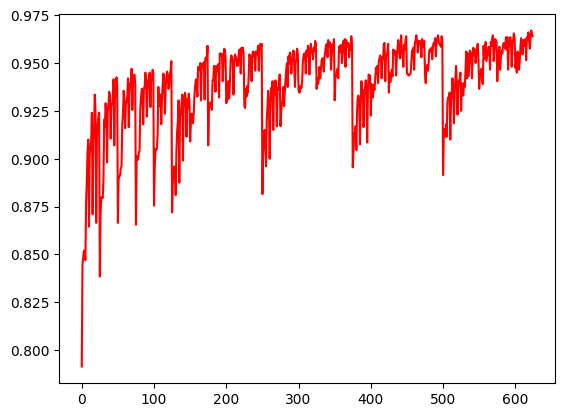

In [16]:
abc1 = np.loadtxt('valid_acc.txt', delimiter=",")
abc2 = np.loadtxt('train_acc.txt', delimiter=",")
plt.plot(abc1, "r")
#plt.plot(abc2, "b")

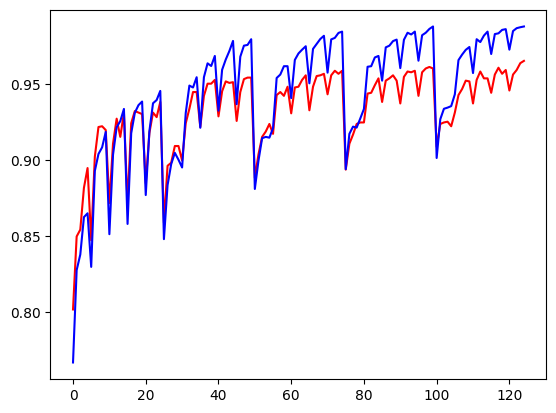

In [9]:
#a1a2a3 10:90
plt.plot(valid_acc_final, "r")
plt.plot(train_acc_final, "b")

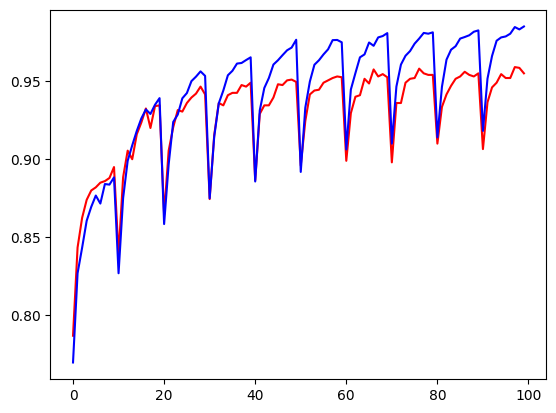

In [83]:
#a1a2 10:100
plt.plot(valid_acc_final, "r")
plt.plot(train_acc_final, "b")

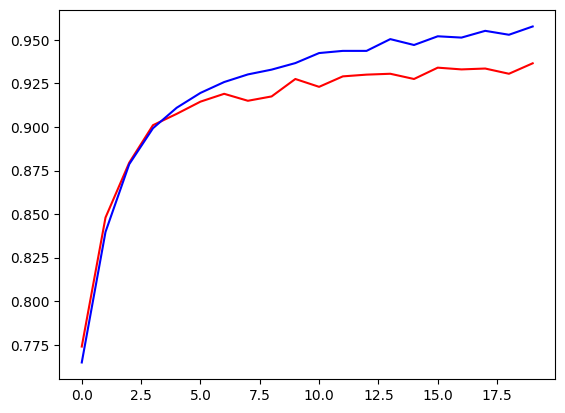

In [78]:
#a1 10:200
plt.plot(valid_acc_final, "r")
plt.plot(train_acc_final, "b")

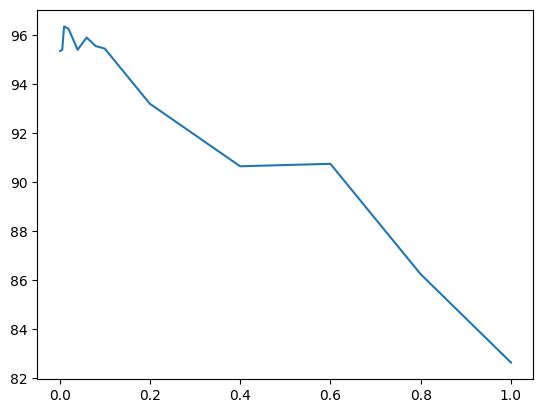

In [53]:
plt.plot([1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.006, 0.001], [82.65, 86.25, 90.75, 90.65, 93.2, 95.45, 95.55, 95.9, 95.4, 96.25, 96.35, 95.9, 95.4, 95.35])

In [24]:
# save the model: you must use the .pth format for pytorch models!
model_savepath = "1.pth"

# To save a PyTorch model, we first pass an input through the model, 
# and then save the "trace". 
# For this purpose, we can use any input. 
# We will create a random input with the proper dimension.
_x = torch.randn(16) # random input
_x = _x[None,:] # add singleton batch index
_x = _x.to(device)
with torch.no_grad():
    traced_cell = torch.jit.trace(net, (_x))

traced_cell.to("cpu")
# Now we save the trace
torch.jit.save(traced_cell, model_savepath)

In [14]:
Xts_savepath = "Xts.csv"
Xtr_savepath = "Xtr.csv"
yts_hat_savepath = "yts_hat.csv"
model_savepath = "1.pth"
!python {"validation.py " + model_savepath + " --Xts_path " + Xts_savepath + " --Xtr_path " + Xtr_savepath + " --yts_hat_path " + yts_hat_savepath } 

usage: validation.py [-h] [--model_path MODEL_PATH] [--Xtr_path XTR_PATH]
                     [--ytr_path YTR_PATH] [--Xts_path XTS_PATH]
                     [--yts_hat_path YTS_HAT_PATH]
validation.py: error: unrecognized arguments: 1.pth
